<img style="float: right;" src="http://www2.le.ac.uk/liscb1.jpg">  
# Leicester Institute of Structural and Chemical Biology: Python for Biochemists
# Assignment 3: Curve fitting

Scipy is the first place to look for general-purpose scientific functionality.  The Scipy library is enormous and varied, so covering all the features is a course unto itself.  Having said that, one of the most commonly used features in scipy is it's fitting routines, which we will now explore.

## Simple Curve fitting

Scipy comes with a number of fitting routines.  One that can be extremely useful is `curve_fit`, which fits a function to a given set of data using a least-squares minimization.  Here, we'll fit some (made up) enzyme kinetics data to the Michaelis-Menten equation:  

$$\large V = \frac{V_{max}[S]}{K_m+[S]}$$  

Where $V$ is the initial rate of the reaction, $V_{max}$ is the rate of the reaction with infinite substrate concentration, $[S]$ is the substrate concentration and ${K_m}$ is the so-called *Michaelis* constant.

The data fitted are a set of values of $V$ measured at various values of $[S]$.

The parameters to be found by the fitting are $V_{max}$ and ${K_m}$.

First, we define the Michaelis-Menten function, which returns the values of $V$ for a series of values of $[S]$. The function accepts in input the values of $[S]$ (abscissae) and the two parameters of the Michaelis-Menten equation, $V_{max}$ and ${K_m}$.

Next - we shall simulate some data - using a pair of $V_{max}$ and ${K_m}$ fixed values.

Then - we shall add noise to our data.

Finally - we shall use `curve_fit` least-squares fitting against our noisy data to obtain values of $V_{max}$ and ${K_m}$ .

In [1]:
def michaelis_menten(s, km, vmax):
    return (vmax*s) / (km + s)

Now - in order to simulate enzymatic measurements of $V$ - we pick some substrate concentrations $[S]$ we (would) do our measurements at:

In [2]:
import numpy as np

In [3]:
substrate_concentrations = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3])

As well as 6 data points, we also want to evaluate the initial velocity for a larger number of closely spaced values of $[S]$.

For this purpose, we'll create a numpy array of 1000 values between x=0 M and x=3 M:

In [4]:
substrate_concentration_range = np.linspace(0, 3, 1000)

Ok, lets make sure this looks right:

0. For our simulated data - we shall choose arbitrarily ${K_m}$=0.1 M and $V_{max}$ =0.5 M/s
1. We'll use plt.scatter to plot the six values of $V$ calculated for the six values of $[S]$. These 6 calculated $V$ values will be stored in an array called initial_velocities.
2. We'll use plt.plot  to plot $V$ calculated for the 1000 values of $[S]$ between 0 and 3 M. These 1000 calculated values of $V$ will be stored in an array called mm_curve. 

As well as the values of $V$ - we shall also plot:

3. A vertical dashed line reaching the MM curve from $V$=0 at abscissa $[S]$=${K_m}$
4. A horizontal dashed line stretching from $[S]$=0 to the MM curve at ordinate $V$=0.5*$V_{max}$ 

For the latter two plots we shall use the Pyplot.vlines and Pyplot.hlines methods.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 0.6)

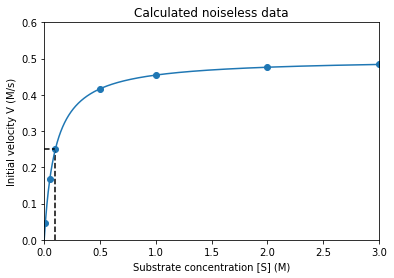

In [6]:
km = 0.1
vmax = 0.5

initial_velocities = michaelis_menten(s=substrate_concentrations, km=km, vmax=vmax)
mm_curve = michaelis_menten(substrate_concentration_range, km, vmax)


# Plot all the things!
plt.scatter(substrate_concentrations, initial_velocities)
plt.plot(substrate_concentration_range, mm_curve)

plt.title("Calculated noiseless data")
plt.ylabel('Initial velocity V (M/s)')
plt.xlabel('Substrate concentration [S] (M)')

# In M-M kinetics, the Km is the substrate concentration where you've reached half-max rate
plt.vlines(km, ymin=0, ymax=vmax/2, linestyle='dashed')
plt.hlines(vmax/2, xmin=0, xmax=km, linestyle='dashed')

plt.xlim(xmin=0, xmax=3)
plt.ylim(ymin=0, ymax=0.6)

Ok, so lets now simulate some noisy data (with Normally distributed noise).

The np.random.normal(loc=l, scale=s, size=n) method will draw n random samples from a normal (Gaussian) distribution centred around loc=l and standard deviation scale=s 
(see https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

We choose loc=0 and scale=0.1 and we add noise to each piece of simulated data in proportion to its value.

In [7]:
number_of_concentrations = len(substrate_concentrations)
noise = (np.random.normal(loc=0, scale=0.1, size=number_of_concentrations))
simulated_data = michaelis_menten(substrate_concentrations, km, vmax)
simulated_noisy_data = simulated_data + (noise*simulated_data)

ok, so how does our simulation look?

Text(0.5, 0, 'Substrate concentration [S] (M)')

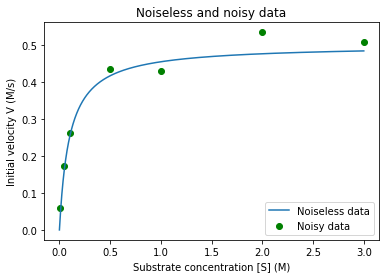

In [8]:
plt.plot(substrate_concentration_range, mm_curve, label='Noiseless data')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='Noisy data', color='green')
plt.legend(loc='lower right');

plt.title("Noiseless and noisy data")
plt.ylabel('Initial velocity V (M/s)')
plt.xlabel('Substrate concentration [S] (M)')

Now we can try to fit a MM curve to the noisy data we have generated.  In order to do this, we need to provide a guess for the initial values of $V_{max}$ and $K_m$ parameters - so that the algorithm can start from somewhere.  

For something as simple as the M-M equation, even quite bad guesses will do. We'll set the starting value of $V_{max}$ to 100 M/s and the starting value for $K_m$ to the last of our simulated_noisy_data values.

In [9]:
initial_guess = (100, simulated_noisy_data[-1])  # Km and Vmax.  Note the Km is a truly horrible guess, given our data
print(initial_guess)

(100, 0.5088042863962753)


In addition, we can provide the fitting algorithm with bounds - regions of allowed values for the parameters.  In this case, it's not necessary, but it's always good to have a sanity check (in this case, both parameters must be positive and we assume no upper bound.)

In [10]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax

In [11]:
from scipy.optimize import curve_fit

fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
print('Km:', fitted[0])
print('Vmax:',fitted[1])

Km: 0.10240159177561836
Vmax: 0.5232697674666398


Remember, always look at your data as much as possible!

Text(0.5, 0, 'Substrate concentration [S] (M)')

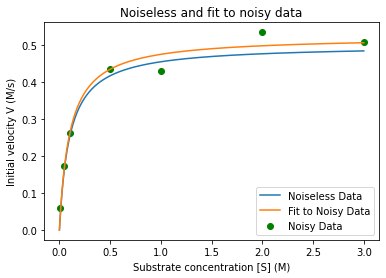

In [12]:
calculated_curve = michaelis_menten(substrate_concentration_range, fitted[0], fitted[1])

plt.plot(substrate_concentration_range, mm_curve, label='Noiseless Data')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='Noisy Data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='Fit to Noisy Data')

plt.legend(loc='lower right');

plt.title("Noiseless and fit to noisy data")
plt.ylabel('Initial velocity V (M/s)')
plt.xlabel('Substrate concentration [S] (M)')

### Exercise 1: Did the fitting actually work?
The easiest way to see if the fitting function returned sensible values is not to just look at the curves!  Instead, the best way is to randomize the starting point. If it keeps giving the same numbers from various starting positions, it's more likely you can trust the results.
1. Generate a random starting value for $K_m$ from 0.01 to 10, and for $V_{max}$ from 0.01 to 10.  *Hint: use `random.uniform()`
2. Fit using these starting values and print both the starting value and resulting parameters.
3. Repeat for 10 total fits.  How does it look?

In [13]:
import numpy as np
from scipy.optimize import curve_fit

fit=0

while fit <= 9:
    print("fit number:", fit)
    random_km=np.random.uniform(0.01,10.0)
    random_vm=np.random.uniform(0.01,10.0)
    initial_guess=(random_km,random_vm)
    
    fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
    print('Km:', fitted[0])
    print('Vmax:',fitted[1])
    fit+=1

fit number: 0
Km: 0.10240158488460814
Vmax: 0.5232697629914332
fit number: 1
Km: 0.1024015810674352
Vmax: 0.5232697604940414
fit number: 2
Km: 0.10240159351217411
Vmax: 0.5232697685696933
fit number: 3
Km: 0.1024016035894551
Vmax: 0.5232697751005868
fit number: 4
Km: 0.10240158572378531
Vmax: 0.5232697634920743
fit number: 5
Km: 0.1024016459467422
Vmax: 0.5232698026261837
fit number: 6
Km: 0.10240163333021628
Vmax: 0.5232697944485065
fit number: 7
Km: 0.10240161468313015
Vmax: 0.5232697823334812
fit number: 8
Km: 0.10240165147824279
Vmax: 0.5232698062054943
fit number: 9
Km: 0.10240154501474988
Vmax: 0.5232697370853115


### Exercise 2:  Compute the fitting error
Compute the errors on the fitted values of $V_{max}$ and $K_m$. 

Curve_fit computes the covariance matrix of the fitted parameters with the method pcov - the pcov matrix is returned by Curve_fit together with the fitted parameters.

The square root of each diagonal element of the covariance matrix can be computed to obtain the error estimated on the corresponding fitted parameter:

perr = np.sqrt(np.diag(covariance))

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

or read the docstring of curve_fit using `.?`, and look at what the function returns.


In [32]:
random_km=np.random.uniform(0.01,10.0)
random_vm=np.random.uniform(0.01,10.0)
initial_guess=(random_km,random_vm)
    
fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
perr = np.sqrt(np.diag(covariance))
print('Km: %.3f' % fitted[0], "plus or minus", '%.3f' % perr[0])
print('Vmax: %.3f' % fitted[1], "plus or minus", '%.3f' % perr[1])


Km: 0.102 plus or minus 0.017
Vmax: 0.523 plus or minus 0.018


Remake the plot, but shade the error bounds: 
1. The MM curve corresponding to the maximum error in the fitted parameters can be computed with $K_m$'=$K_m$-err($K_m$) and $V_{max}$'=$V_{max}$+err($V_{max}$)
2. The MM curve corresponding to the minimimum error in the fitted parameters can be computed with $K_m$"=$K_m$+err($K_m$) and $V_{max}$"=$V_{max}$-err($V_{max}$)
3. Calculate the curve for the maximum and minimum errors as we did above
4. Ask google how to fill between curves in matplotlib: a common application for plt.fill_between is the indication of confidence bands. fill_between uses the colors of the color cycle as the fill color. These may be a bit strong when applied to fill areas. It is therefore often a good practice to lighten the color by making the area semi-transparent using alpha. Try setting `alpha=0.2` in the plotting function.

Text(0.5, 0, 'Substrate concentration [S] (M)')

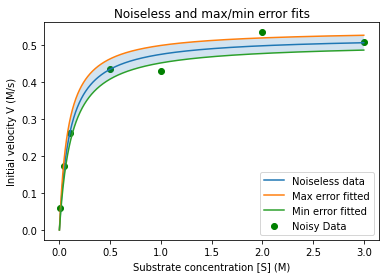

In [36]:

km_max_err=fitted[0]-perr[0]
vm_max_err=fitted[1]+perr[1]
simulated_data_max_err = michaelis_menten(substrate_concentration_range, km_max_err, vm_max_err)


km_min_err=fitted[0]+perr[0]
vm_min_err=fitted[1]-perr[1]
simulated_data_min_err = michaelis_menten(substrate_concentration_range, km_min_err, vm_min_err)

plt.plot(substrate_concentration_range, calculated_curve, label='Noiseless data')

plt.plot(substrate_concentration_range, simulated_data_max_err, label='Max error fitted')

plt.plot(substrate_concentration_range, simulated_data_min_err, label='Min error fitted')

plt.scatter(substrate_concentrations, simulated_noisy_data, label='Noisy Data', color='green')

plt.fill_between(substrate_concentration_range, simulated_data_max_err, simulated_data_min_err, alpha=0.2)

plt.legend(loc='lower right');
plt.title("Noiseless and max/min error fits")
plt.ylabel('Initial velocity V (M/s)')
plt.xlabel('Substrate concentration [S] (M)')

## Uncertainty

In the fit above, we used the covariance matrix to determine the error bounds.  What's not so apparent from this is that this only works for some fitting algorithm (including linear least-squares - by-far the most commonly used fitting algorithm), is only valid if the errors are normally distributed, and is then only valid if the data is homoscedastic (the measurement error is the same for every point - which isn't really true in this case!)  

So what are we to do?
1.  Work out the analytical error for every fit, assuming the characteristics of the error (hard - lots of algebra)
2.  Use resampling to empirically determine the distribution of parameter values (hard - lots of computation)

Except #2 isn't hard - we have computers to do the computation for us.  The type of resampling we'll be doing is call bootstrapping.  The mathematical justification for why this works is (way) beyond this course.  But the important result is that, if you follow a few rules, you can approximate the actual underlying distribution on almost any parameter, and then extract what you want directly.  Here are the rules:
1. Generate a new set of data by sampling, with replacement, from your current data set.
2. The new data set must have the same number of observations as the original (some data will get repeated, some left out)
3. Fit your curve with the new dataset
4. Repeat a few hundred to tens of thousands of times until the distribution stabilizes

An example in code should make this clear:

In [14]:
def make_bootstrap_sample(original_sample_x, original_sample_y):
    assert len(original_sample_x) == len(original_sample_y)
    indices = np.arange(len(original_sample_x)-1)
    resample_indices = np.random.choice(indices, size=len(indices), replace=True)
    resampled_x = original_sample_x[resample_indices]
    resampled_y = original_sample_y[resample_indices]
    return resampled_x, resampled_y

In [15]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
initial_guess = (1, simulated_noisy_data[-1])  # Km and Vmax.

bootstrap_values =[]

iterations = 1000

for _ in range(iterations):
    # Generate new sample indices with replacement 
    resampled_s, resampled_d = make_bootstrap_sample(substrate_concentrations, simulated_noisy_data)
    
    # Fit the curve with the resampled dataset
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=resampled_s,
                                                       ydata=resampled_d,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    bootstrap_values.append(bootstrap_fitted)
    
bootstrap_kms = tuple(v[0] for v in bootstrap_values)
bootstrap_vmaxs = tuple(v[1] for v in bootstrap_values)

Now look at the results

1000

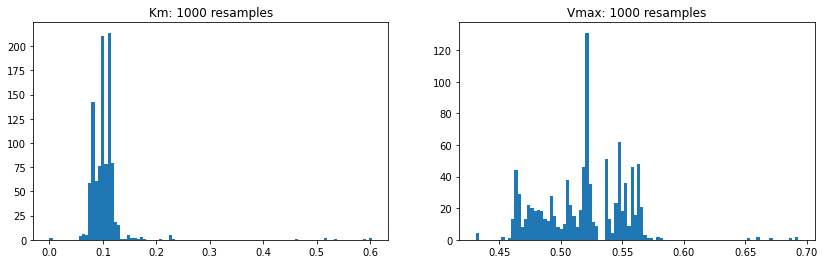

In [16]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(bootstrap_kms, bins=100)
# plt.xlim(0,1)
plt.title(f'Km: {len(bootstrap_kms)} resamples')

plt.subplot(122)
plt.hist(bootstrap_vmaxs, bins=100)
# plt.xlim(0,2)
plt.title(f'Vmax: {len(bootstrap_vmaxs)} resamples');

len(bootstrap_kms)

Notice that the plots above aren't that smooth, and have some outliers.  Lets repeat the bootstrap with 10 000 iterations (start this running now, while you read the instructions for Exercise 3.)

10000

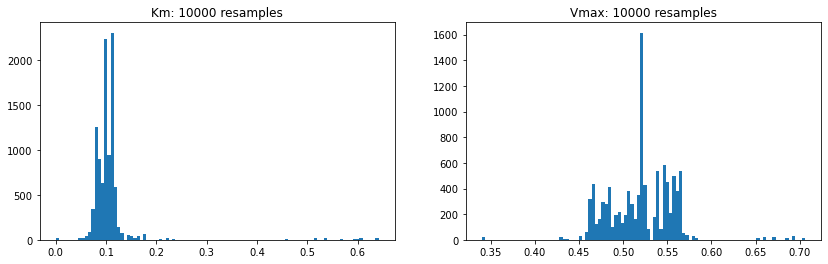

In [17]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
initial_guess = (1, simulated_noisy_data[-1])  # Km and Vmax.

bootstrap_values =[]

iterations = 10000

for _ in range(iterations):
    # Generate new sample indices with replacement 
    resampled_s, resampled_d = make_bootstrap_sample(substrate_concentrations, simulated_noisy_data)
    
    # Fit the curve with the resampled dataset
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=resampled_s,
                                                       ydata=resampled_d,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    bootstrap_values.append(bootstrap_fitted)
    
bootstrap_kms = tuple(v[0] for v in bootstrap_values)
bootstrap_vmaxs = tuple(v[1] for v in bootstrap_values)
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(bootstrap_kms, bins=100)
# plt.xlim(0,1)
plt.title(f'Km: {len(bootstrap_kms)} resamples')

plt.subplot(122)
plt.hist(bootstrap_vmaxs, bins=100)
# plt.xlim(0,2)
plt.title(f'Vmax: {len(bootstrap_vmaxs)} resamples');

len(bootstrap_kms)

### Exercise 3: Confidence interval
The 90% confidence interval is the range of values that contain the central 90% of the distribution.  Extract the 90%  CI for the data above.
1. Make sure you've started the 10 000 iterations above.
2. Make sorted listes of bootstrap_kms and bootstrap_vmaxs
3. If you have 10000 sorted data points, the central 9000 data points make up your 90% CI - extract the lowest and hightest values from these 9000
4. Use `plt.scatter` to plot all 10000 points.  What do you notice?
4. Eliminate any datapoint with $K_m$ or $Vmax$ values outside the 90% central data, and polt these points.  What do you notice?
5. Make two plots comparing the fitting error to the 90% CI.  First, plot the $K_m$ CI using the originally fitted $V_{max}$, then plot the $V_{max}$ CI using the originally fitted $K_m$.

One thing to note here:  The confidence intervals *are not centered on the prediction*, this means that, given our data, we're more certain about one bound than the other.  Because we've used random noise, your intervals may appear centered, but if you run the notebook again, you may be able to see that they're not.

So what's going on here?  Why did our "Fitting Error" above give us a single bound centered on the data?  The covariance matrix method assumes the data is normally distributed - so the error with be the same both 'above' and 'below' the true value.  It also assumes that the X and Y values are NOT correlated - which they are here.  

So which to use?  If you want to know how good the program fit your data, use the covariance method.  If you want to know how well your experiment's determined the true parameters, use the bootstrap.  It really is that simple.

Finally - what can we do to improve our precision?

### Exercise 4: Experimental replicates
Most experiments will have replicate data points, i.e. the researcher measures the initial rate several times at each substrate concentration.
1. Create a new list of substrate concentrations called `substrate_concentrations_with_replicates`, using each concentration three times (order doesn't matter)
2. Create new simulated data called `simulated_data_with_replicates` from above, adding the same *amount* of random noise (but not the same set of random numbers) as for `simulated_noisy_data`
3. Fit the data and calculate the 90% CI with the replicates.  Make plots of the distributions.
What do you notice?

## Model choice

One common difficulty in analysing data is choosing the correct model.  The most tempting choice is the model that fits our data best - *this is extremely dangerous.*  Here's the equation for homotropic alosterism (substrate activation or inhibition of the enzyme):  

$$\large V = \frac{V_{max}\frac{[S]}{K_{D1}} + \beta V_{max}\frac{[S]^2}{\alpha K_{D1}K_{D12}}}{1 + \frac{[S]}{K_{D1}} + \frac{[S]}{K_{D2}} + \frac{[S]^2}{\alpha K_{D1} K_{D2}}}$$  

Now, **we know that our system doesn't have any substrate inhibition or activation** - we created the data afterall - but lets see how this does...

In [18]:
def michaelis_menten_ha(s, kd1, kd2, alpha, beta, vmax):
    '''
    The Michaelis-Menton function including homotropic allosterism. 
    '''
    numerator = vmax * (s/kd1) + (beta * vmax * (s**2)/(alpha * kd1 *kd2))
    denominator = 1 + (s/kd1) + (s/kd2) + (s**2)/(alpha * kd1 * kd2)
    
    return numerator/denominator

If we set $\alpha$ and $\beta$ to be 1, and set $K_{D1}$ and $K_{D2}$ to the same value, the equation above reduces to the standard Michaelis-Menton equation, so we'll set our starting parameters there.

In [19]:
initial_guess = (fitted[0], fitted[0], 1, 1, fitted[1])  # KD1, KD2, alpha, beta and Vmax
lower_bounds_ha = (0, 0, 0, 0, 0)
upper_bounds_ha = (np.inf, np.inf, np.inf, np.inf, np.inf)

fitted_ha, covariance_ha = curve_fit(f=michaelis_menten_ha,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds_ha, upper_bounds_ha)
                              )

print('Original Michaelis-Menton')
print('Km:', fitted[0])
print('Vmax:',fitted[1])

print()

print('Michaelis-Menton with aditional parameters')
print('KD1', fitted_ha[0])
print('KD2:',fitted_ha[1])
print('alpha:', fitted_ha[2])
print('beta:',fitted_ha[3])
print('Vmax:', fitted_ha[4])

Original Michaelis-Menton
Km: 0.10240154501474988
Vmax: 0.5232697370853115

Michaelis-Menton with aditional parameters
KD1 0.08965458311717264
KD2: 0.579227334479527
alpha: 4.228857905441195
beta: 1.161336064144945
Vmax: 0.5196420420682225


Ok, so now which one fits our data better?

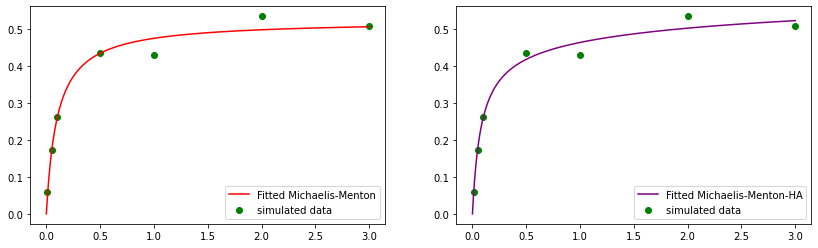

In [20]:
calculated_curve_ha = michaelis_menten_ha(substrate_concentration_range,
                                          *fitted_ha)  # *fitted_ha => fitted_ha[0], fitted_ha[1]

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='Fitted Michaelis-Menton', color='red')
plt.legend(loc='lower right')

plt.subplot(122)
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve_ha, label='Fitted Michaelis-Menton-HA', color='purple')
plt.legend(loc='lower right');

Which one do you think looks better?

So what does this mean?  Because the  `michaelis_menten_ha` function is the `michaelis_menten` function with three extra parameters, it will **always** fit noisy data better.  Because we used the `michaelis_menten` function to generate the data, we know that's the one we should actually be using, though.  If you're faced with a real-world problem, and the function with more parameters will always fit noisy data better, how can you tell if you really should use the function with more parameters or not?

## Model selection by cross validation

How do you know which model to choose?  One of the best ways is cross-validation.  The key to undersanding why this is so powerful is that cross-validation essentially tests how much of the random noise you're modelling.  The function that models the least noise and most signal is almost always the correct one. 

Cross-validation leaves a bit of data out, then fits (trains) the curve without that data, then tests how well the left out data is predicted by the fit.

We'll start with leave-one-out cross validation:

In [21]:
initial_guess = (100, simulated_noisy_data[-1])  # Km and Vmax.  Note the Km is a truly horrible guess, given our data
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
predictions = []

# Step through each substrate concentration
for i in range(len(substrate_concentrations)):
    
    # Build a mask excluding the test measurement
    mask = np.ones(len(substrate_concentrations)).astype('bool')
    mask[i] = False
    
    # Remove the test measurement from our training data
    training_substrate_concentrations = substrate_concentrations[mask]
    training_simulated_data = simulated_noisy_data[mask]
    
    # Fit the curve
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=training_substrate_concentrations,
                                                       ydata=training_simulated_data,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    predictions.append(michaelis_menten(substrate_concentrations[i], *fitted))

abs_errors = abs(predictions - simulated_noisy_data)
xval_error = sum(abs_errors)
print("Cross validation error for 'michaelis_menten':",xval_error)

Cross validation error for 'michaelis_menten': 0.0999161424942154


### Exercise 5: Model selection by cross validation
Run the cross validation on `michaelis_menten_ha`.  Which function gives lower cross-validation error?  

*Hint: If you get `Optimal parameters not found` error, add the parameter `max_nfev=10000` to the `curve_fit` call.*


So which model do we choose?

In [22]:
xval_ratio = xval_error / xval_ha_error

if xval_ratio < 0.95:
    print('Michaelis-Menton is the prefered model.')
elif 1/xval_ratio < 0.95:
    print('Michaelis-Menton with Homotropic Alostery is the prefered model.')
else:
    print("The cross validation scores are too close, we can't descriminiate between the models")

NameError: name 'xval_ha_error' is not defined

As always, there are lots of choices for how exactly we do cross-validation, but here are the two most import issues:

1. If you only have a few more observations than parameters, do leave-one-out validation.
2. If you have correlated data (i.e. several blocks of data,) try to keep the correlated data either in the test or training sets  

In general, if you have many more data points than parameters, you can do k-fold cross validation.  For example, with 5-fold cross-validation, you would split your data into 5 chunks, using 4 of the chunks for training and one for error determination.  As you have 5 chunks, you do it 5 times (using a different chunk each time,) and sum up the errors.  The model with the lowest error is the one over-fitting the least.